# Grover's Algorithm Visualisation
Below we implement a function to help visualise the evolution of the state in the $(|s'\rangle, |w\rangle)$ plane during Grover's algorithm (see end).

In [1]:
#initialization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import numpy as np
import seaborn as sns

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex

The cell below just defines a load of functions for Grover's algorithm, including `calculate_repetitions` to calculate the number of Grover iterations required.

In [13]:
#initialize equal superposition
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def append_oracle(qc,n, solutions):
    qc.barrier()
    for j in range(0, len(solutions)):
        sol = solutions[j]
        for i in range(0, n):
            if sol[i] == '0':
                qc.x(n-1-i)
        qc.mct(list(range(0,n)),n)
        for i in range(0, n):
            if sol[i] == '0':
                qc.x(n-1-i)
        qc.barrier()
    return qc

#implement diffuser

def append_diffuser(qc,n):
# Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(n):
        qc.h(qubit)
    
# Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(n):
        qc.x(qubit)
    
# Do multi-controlled-Z gate
    qc.barrier()
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    qc.barrier()

# Apply transformation |11..1> -> |00..0>
    for qubit in range(n):
        qc.x(qubit)
    
# Apply transformation |00..0> -> |s>
    for qubit in range(n):
        qc.h(qubit)
    
    qc.barrier()
    return qc


def one_iteration(qc,n,solutions):
    qc= append_oracle(qc,n,solutions)
    qc= append_diffuser(qc,n)
    return qc

def calculate_repetitions(N, M):
    sMN = np.sqrt(M/N)
    theta = 2 * np.arcsin(sMN)
    number = np.arccos(sMN)/theta
    result = int(round(number))
    if result < 1:
        return 1
    else:
        return result

An example circuit (can edit the solutions):

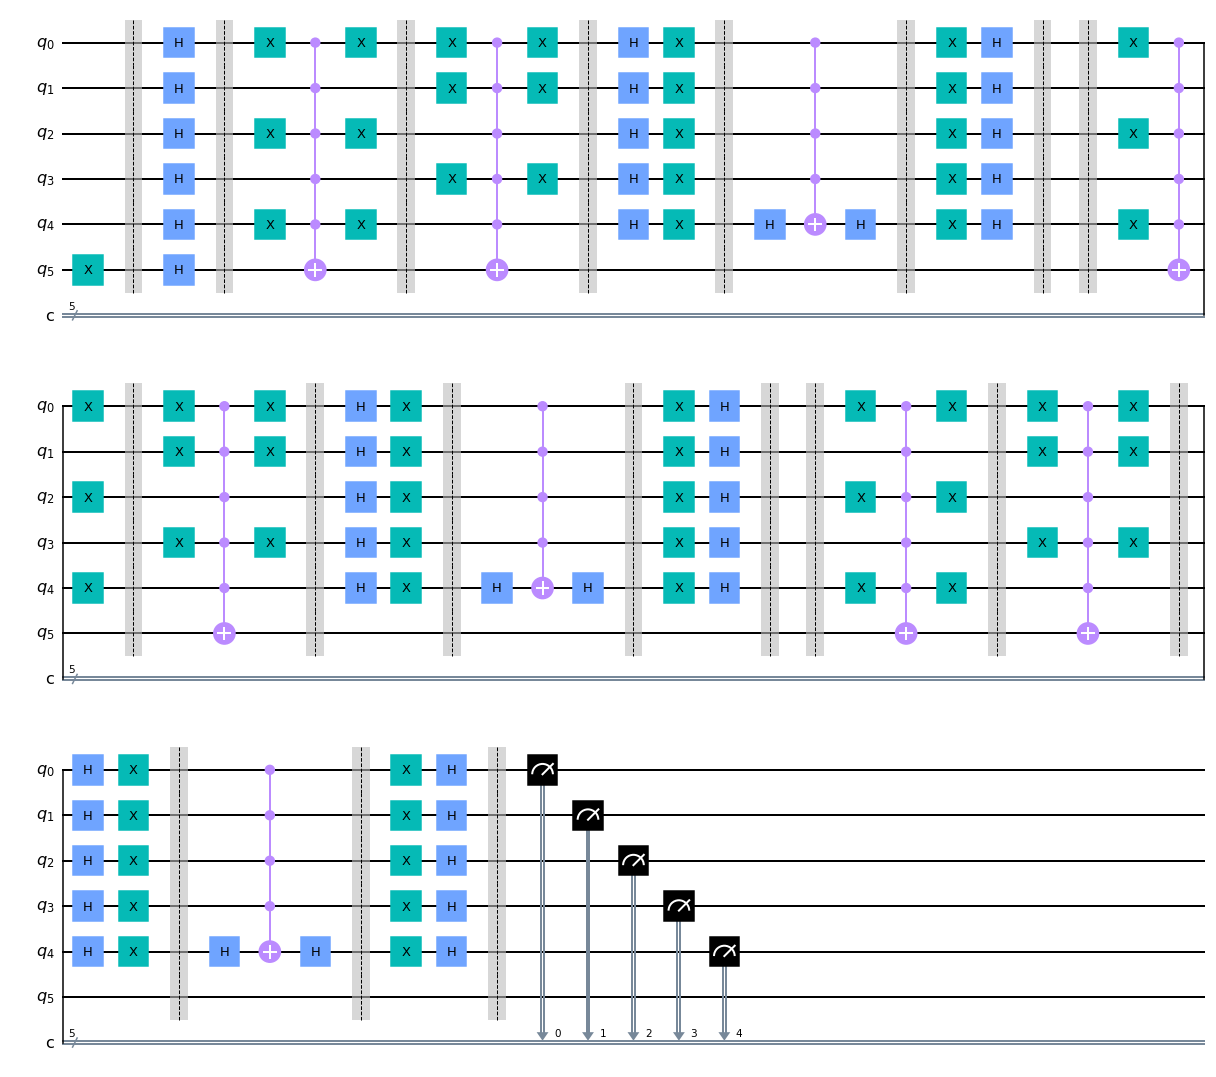

In [28]:
#choose circuit size
n = 5
grover_circuit = QuantumCircuit(n+1,n)

#create circuit + ancilla
#intialize ancilla in |->
grover_circuit.x(n)
grover_circuit.barrier()

# input solutions here
solutions = ['01010','10100']
R = calculate_repetitions(2**n, len(solutions))

grover_circuit= initialize_s(grover_circuit, list(range(0,n+1)))

for index in range(0,R):
    grover_circuit = one_iteration(grover_circuit, n, solutions)

grover_circuit.measure(range(0,n),range(0,n))

grover_circuit.draw('mpl')

Visualisation below!

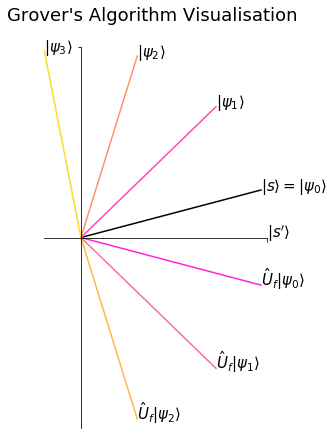

In [32]:
def visualize_Grover(N, M):
    sMN = np.sqrt(M/N)
    theta = 2 * np.arcsin(sMN)
    xs = np.array([0, np.cos(theta/2)])
    ys = np.array([0, np.sin(theta/2)])
    
    sns.set_palette('spring')
    fig = plt.figure(figsize=(4, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(-0.2, 1)
    plt.ylim(-1, 1)
    
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('center')
    
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Set x- and y-ticks
    ax.set_xticks([1])
    ax.set_yticks([1])
    ax.annotate(r"$|s'\rangle$", (1, 0))
    
    # Set their labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.plot(xs, ys, 'black')
    plt.annotate(r'$|s\rangle = |\psi_0\rangle$', (xs[1], ys[1]))
    for k in range(1, calculate_repetitions(N, M)+1):
        # oracle reflects about |s'>
        plt.plot(xs, -ys)
        plt.annotate(fr"$\hat U_f |\psi_{k-1}\rangle$", (xs[1], -ys[1]))
        # diffuser reflects about |s>
        arg = (2*k + 1)*theta/2
        xs = np.array([0, np.cos(arg)])
        ys = np.array([0, np.sin(arg)])
        plt.plot(xs, ys)
        plt.annotate(fr"$|\psi_{k}\rangle$", (xs[1], ys[1]))
    
    plt.title("Grover's Algorithm Visualisation \n")
    plt.show()
    
visualize_Grover(2**n, len(solutions))

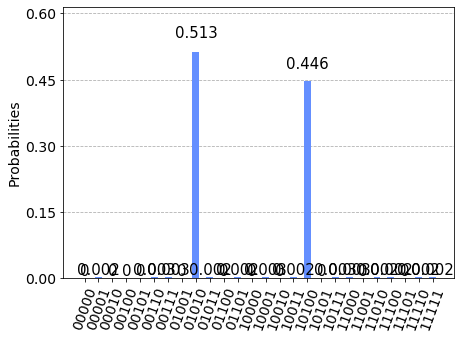

In [30]:
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)